In [1]:
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env

# Functions

In [2]:
def clean(df):
    '''
    This Function filters out the df by the city of Los Angeles, drops columns,
    renames, sets the index to the date, & converts to Fahrenheit
    
    '''
    
    # Filtering out by USA
    df = df[df.Country == "United States"]
    
    # Filtering out by Los Angeles
    df = df[df.City == "Los Angeles"]
    
    # Dropping columns that wont be needed
    df = df.drop(columns=['Country', 'Latitude', 'Longitude', 'City', 'AverageTemperatureUncertainty'])
    
    # Renaming AverageTemperature to just temp
    df = df.rename(columns={"AverageTemperature": "temp"})
    
    # Converting sale_date type object to datetime64
    df.dt = pd.to_datetime(df.dt)
    
    # Removing dates before 2010-09-01, leaving me excatly 3 years
    df = df[~(df['dt'] < '2009-09-01')]
    
    # Resetting the index to datetime
    df = df.set_index('dt').sort_index()
    
    # Convert to fahrenheit
    df.temp = df.temp.apply(celsius_to_fahrenheit)
    
    return df

In [3]:
def celsius_to_fahrenheit(c):
    c = float(c)
    c = (c*(9/5)) + 32
    return c

In [4]:
def split(df):
    '''
    Splits the data into train, validate, and split. Then resampling by Month
    '''
    # Train 09/2009 - 12/2011
    train = df['2009-09-01':'2011-12-01']
    
    # Validate 12/2011 - 12/2012
    validate = df['2011-12-01':'2012-12-01']
    
    # Test 12/2012 - 09/2013
    test = df['2012-12-01':'2013-09-01']
    
        
    # Resampling it so it has a Frequency = "M"
    train = train.resample('M').mean()
    validate = validate.resample('M').mean()
    test = test.resample('M').mean()
    
    return train, validate, test

### Plotting Defaults

In [5]:
plt.rc('figure', figsize=(9, 4))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

# Acquire

In [6]:
# Importing saas.csv to a Data Frame
df = pd.read_csv('temp_city.csv')

In [7]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


# Prepare

### Clean

In [9]:
df = clean(df)

### Split

In [10]:
train, validate, test = split(df)

### Plot the Split

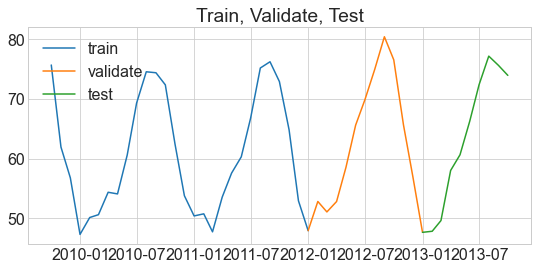

In [11]:
plt.plot(train.index, train.temp, label='train')
plt.plot(validate.index, validate.temp, label='validate')
plt.plot(test.index, test.temp, label='test')
plt.xticks(rotation=0)
plt.title(label='Train, Validate, Test')
plt.legend()
plt.show()

### Shape

In [12]:
train.shape

(28, 1)

In [13]:
validate.shape

(13, 1)

In [14]:
test.shape

(10, 1)

# Explore

### Graphing

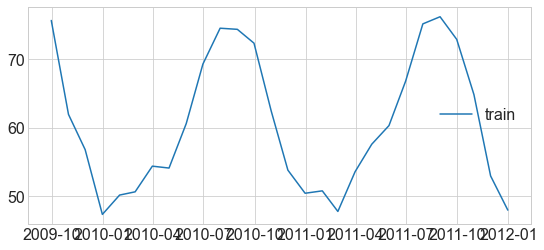

In [15]:
# Taking a look at my train
plt.plot(train.index, train.temp, label='train')
plt.legend()
plt.show()

### Questions

    What is the Average temp?

In [20]:
train.temp.mean()

60.564842857142864

    What is Coldest Month?

In [21]:
train.temp.min()

47.3342

    What is the Hottest Month?

In [ ]:
train.temp.